### Classificatore
Il classificatore è un modello semplice con pochi layer densi e un layer finale per la classificazione con la softmax.\
Essendo i dati molto più piccoli le batch possono essere alte e si possono avere molte più epoche per far imparare.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

# Options: "covid_cxr" or "syntetic"
dataset_name = "syntetic"
epochs = 20
batch = 1024

root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}_embeddings.npz"
cache_path = f"{root}/datasets/{dataset_name}_predictions.npz"
model_save_path = f"{root}/models/{dataset_name}_classifier.keras"

Il dataset (già modificato in embeddings) viene caricato in modo da avere in input le rappresentazioni latenti delle immagini e la classe a cui appartiene.

In [2]:
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

latent_space = x_train.shape[1]

Purtroppo essendo il dataset molto sbilanciato verso una classe l'addestramento viene influenzato negativamente se non si fanno delle correzioni.

Train samples: 35000, Validation samples: 7500, Test samples: 7500
Train shape: (35000, 1024), Validation shape: (7500, 1024), Test shape: (7500, 1024)


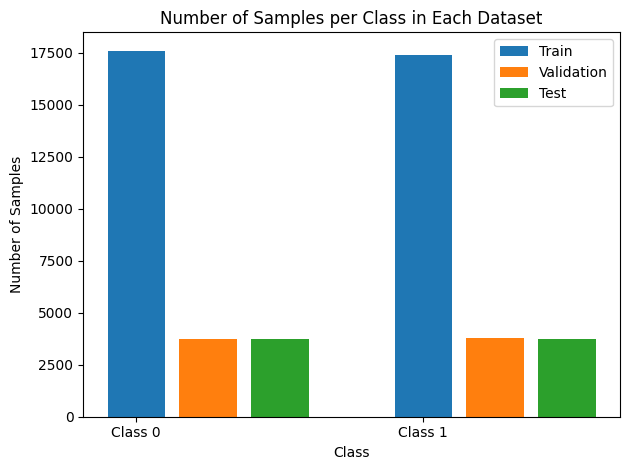

In [3]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

print(f"Train samples: {len(y_train)}, Validation samples: {len(y_val)}, Test samples: {len(y_test)}")
print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")

total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}

plt.figure()
x_labels = range(total_classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train', align='center')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation', align='center')
plt.bar([x + 0.5 for x in x_labels], test_counts, width=0.2, label='Test', align='center')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Each Dataset')
plt.legend()
plt.tight_layout()
plt.show()

La struttura del classificatore.\
Questo modello verrà valutato tramite *sparse_categorical_crossentropy* dato che restituirà un array con le probabilità per ogni classe.

In [4]:
in_classifier = layers.Input(shape=(latent_space,), dtype='float32')
#x = layers.BatchNormalization()(in_classifier)
x = layers.Dense(latent_space)(in_classifier)
x = layers.Dropout(0.2)(x)
out_classifier = layers.Dense(total_classes, activation='softmax')(x)

classifier = models.Model(in_classifier, out_classifier, name='classifier')
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,051,650 (4.01 MB)

 Trainable params: 1,051,650 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In questa porzione di codice il modello viene addestrato

In [5]:
history = classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                         epochs=epochs,
                         batch_size=batch, class_weight=class_weights,
                         callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.5752 - loss: 0.6829 - val_accuracy: 0.7217 - val_loss: 0.6379
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8203 - loss: 0.5773 - val_accuracy: 0.8283 - val_loss: 0.4984
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8443 - loss: 0.4258 - val_accuracy: 0.8521 - val_loss: 0.3717
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8627 - loss: 0.3390 - val_accuracy: 0.8701 - val_loss: 0.3208
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8807 - loss: 0.2965 - val_accuracy: 0.8813 - val_loss: 0.2913
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8863 - loss: 0.2773 - val_accuracy: 0.8869 - val_loss: 0.2774
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8936 - loss: 0.2616 - val_accuracy: 0.8867 - val_loss: 0.2767
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8889 - loss: 0.2656 - val_accuracy: 0.8921 - val_lo

Di seguito la loss nel tempo

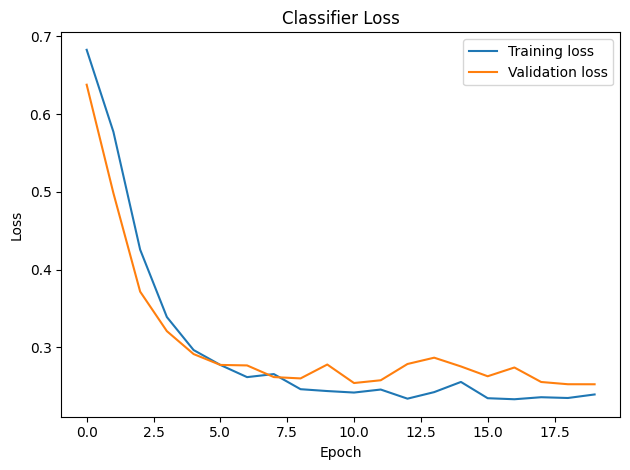

In [6]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Il risultato è che il classificatore riesce a distinguere abbastanza bene nella parte di training mentre fallisce nel generalizzare

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


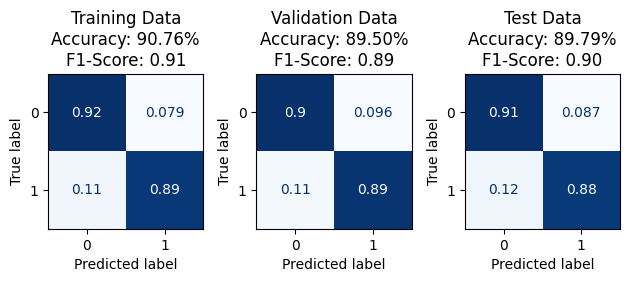

In [7]:
classifier = models.load_model(model_save_path)

y_train_pred = np.argmax(classifier.predict(x_train), axis=1)
y_val_pred = np.argmax(classifier.predict(x_val), axis=1)
y_test_pred = np.argmax(classifier.predict(x_test), axis=1)

datasets = [
    ("Training Data", y_train, y_train_pred),
    ("Validation Data", y_val, y_val_pred),
    ("Test Data", y_test, y_test_pred)
]

_, axes = plt.subplots(1, len(datasets), figsize=None)
for i, (title, y_true, y_pred) in enumerate(datasets):
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize='true',
        display_labels=[i for i in range(total_classes)],
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=axes[i]
    )
    axes[i].set_title(f"{title}\n"
                        + f"Accuracy: {balanced_accuracy_score(y_true, y_pred):.2%}\n"
                        + f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.2f}")
plt.tight_layout()
plt.show()

In [8]:
# Save the embeddings predictions and true labels
print(f"Shapes: "
      f"x_train: {x_train.shape}, y_train: {y_train.shape}, y_train_pred: {y_train_pred.shape}\n"
      f"x_val: {x_val.shape}, y_val: {y_val.shape}, y_val_pred: {y_val_pred.shape}\n"
      f"x_test: {x_test.shape}, y_test: {y_test.shape}, y_test_pred: {y_test_pred.shape}\n"
      f"latent_space: {latent_space}, total_classes: {total_classes}, class_weights: {class_weights}")

np.savez(cache_path,
         y_train_pred=y_train_pred,
         y_val_pred=y_val_pred,
         y_test_pred=y_test_pred)

Shapes: x_train: (35000, 1024), y_train: (35000,), y_train_pred: (35000,)
x_val: (7500, 1024), y_val: (7500,), y_val_pred: (7500,)
x_test: (7500, 1024), y_test: (7500,), y_test_pred: (7500,)
latent_space: 1024, total_classes: 2, class_weights: {0: np.float64(0.9939793252300352), 1: np.float64(1.0060940554214097)}
